In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Train, Test
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, TimeSeriesSplit

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Cargamos el scaler que usamos para escalar los datos previamente

with open('SO2_x_scaler.pkl', 'rb') as file:
    SO2_x_scaler = pickle.load(file)
with open('SO2_y_scaler.pkl', 'rb') as file:
    SO2_y_scaler = pickle.load(file)
    
with open('NO2_x_scaler.pkl', 'rb') as file:
    NO2_x_scaler = pickle.load(file)
with open('NO2_y_scaler.pkl', 'rb') as file:
    NO2_y_scaler = pickle.load(file)
    
with open('O3_x_scaler.pkl', 'rb') as file:
    O3_x_scaler = pickle.load(file)
with open('O3_y_scaler.pkl', 'rb') as file:
    O3_y_scaler = pickle.load(file)
    
with open('CO_x_scaler.pkl', 'rb') as file:
    CO_x_scaler = pickle.load(file)
with open('CO_y_scaler.pkl', 'rb') as file:
    CO_y_scaler = pickle.load(file)
    
with open('PM10_x_scaler.pkl', 'rb') as file:
    PM10_x_scaler = pickle.load(file)
with open('PM10_y_scaler.pkl', 'rb') as file:
    PM10_y_scaler = pickle.load(file)
    
with open('PM2.5_x_scaler.pkl', 'rb') as file:
    PM2_5_x_scaler = pickle.load(file)
with open('PM2.5_y_scaler.pkl', 'rb') as file:
    PM2_5_y_scaler = pickle.load(file)

In [5]:
df_SO2 = pd.read_csv('../../data/processed/SO2_process.csv')
df_NO2 = pd.read_csv('../../data/processed/NO2_process.csv')
df_O3 = pd.read_csv('../../data/processed/O3_process.csv')
df_CO = pd.read_csv('../../data/processed/CO_process.csv')
df_PM10 = pd.read_csv('../../data/processed/PM10_process.csv')
df_PM2_5 = pd.read_csv('../../data/processed/PM2_5_process.csv')

In [6]:
def x_y_split(df):    
    x = df.drop(columns = ['Measurement value', 'Measurement date'], axis=1)  
    y = df['Measurement value']  
    
    # Dividir el conjunto en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

    return  x_train, x_test, y_train, y_test

In [7]:
def x_y_def(df):    
    x = df.drop(columns = ['Measurement value', 'Measurement date'], axis=1)  
    y = df['Measurement value']  

    return  x, y

In [8]:
SO2_x_train, SO2_x_test, SO2_y_train, SO2_y_test = x_y_split(df_SO2)
NO2_x_train, NO2_x_test, NO2_y_train, NO2_y_test = x_y_split(df_NO2)
O3_x_train, O3_x_test, O3_y_train, O3_y_test = x_y_split(df_O3)
COx_train, COx_test, COy_train, COy_test = x_y_split(df_CO)
PM10x_train, PM10x_test, PM10y_train, PM10y_test = x_y_split(df_PM10)
PM2_x_train, PM2_x_test, PM2_y_train, PM2_y_test = x_y_split(df_PM2_5)

In [9]:
SO2_x, SO2_y = x_y_def(df_SO2)
NO2_x, NO2_y = x_y_def(df_NO2)
O3_x, O3_y = x_y_def(df_O3)
CO_x, CO_y = x_y_def(df_CO)
PM10_x, PM10_y = x_y_def(df_PM10)
PM2_x, PM2_y = x_y_def(df_PM2_5)

In [10]:
SO2_x.head(1)

,hour,week_of_year,year,lag_1,rolling_mean_4,rolling_mean_8,rolling_mean_12,hourly_season_avg,last_week_hourly_mean,last_month_hourly_mean,sin_season,cos_season,sin_month,cos_month
0,0.0,1.0,0.0,0.333333,0.481481,0.481481,0.504854,0.4985,0.565217,0.558222,0.5,1.0,0.75,0.933013


In [11]:
modelos = {
    "random_forest": RandomForestRegressor(),
    "decision_tree": DecisionTreeRegressor(),
    "gradient_boosting": GradientBoostingRegressor(),
    "adaboost": AdaBoostRegressor(),
    "kneighbors": KNeighborsRegressor(),
    "linear_regressor": LinearRegression(),
    "svr": SVR()
}

In [12]:
def best_model(x_train, x_test, y_train, y_test, y_scaler):

    resultados = []

    for regresor, modelo in modelos.items():
        modelo.fit(x_train, y_train)

        y_pred = modelo.predict(x_test)
        y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
        y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
        mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
        r2 = r2_score(y_test_unscaled, y_pred_unscaled)

        resultados.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})

    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(by = "R2_score", ascending = False)
    
    return df_resultados

## SO2 MODEL

%%time
best_model (SO2_x_train, SO2_x_test, SO2_y_train, SO2_y_test, SO2_y_scaler )

In [15]:
gradient_best_params = {'criterion': 'friedman_mse', 'learning_rate': 0.05, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 33, 'subsample': 0.8}

In [115]:
SO2_model = LinearRegression()

# Crear el objeto TimeSeriesSplit (por ejemplo, 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(SO2_model, SO2_x, SO2_y, cv=tscv, scoring='r2')
print("R2 scores:", scores)
print("R2 promedio:", np.mean(scores))

R2 scores: [0.68794796 0.8006754  0.75709536 0.80267986 0.82125585]
R2 promedio: 0.7739308833401053


In [124]:
%%time
# Entrenamos el modelo
SO2_model.fit(SO2_x, SO2_y)

CPU times: total: 15.6 ms
Wall time: 7.75 ms


LinearRegression()

In [122]:
# Calculamos Feature Importance
importances = SO2_model.feature_importances_

df_importances = pd.DataFrame(data = zip(SO2_x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [18]:
with open("../../models/SO2_model_task_2.pkl", "bw") as file:
    pickle.dump(SO2_model, file)

## NO2 MODEL

%%time
best_model (NO2_x_train, NO2_x_test, NO2_y_train, NO2_y_test, NO2_y_scaler )

In [21]:
randomforest_best_params = {'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 33}

In [22]:
NO2_model = RandomForestRegressor(**randomforest_best_params)

# Crear el objeto TimeSeriesSplit (por ejemplo, 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(NO2_model, NO2_x, NO2_y, cv=tscv, scoring='r2')
print("R2 scores:", scores)
print("R2 promedio:", np.mean(scores))

R2 scores: [0.8258332  0.90929684 0.87336526 0.91952373 0.90827104]
R2 promedio: 0.8872580138405194


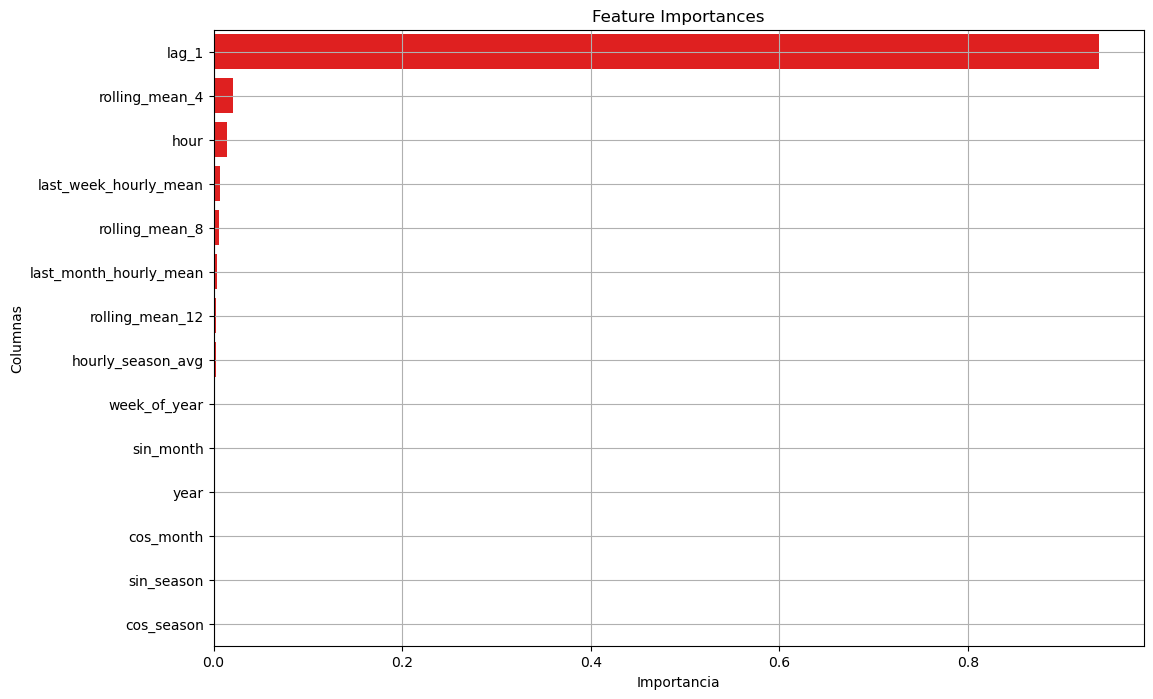

CPU times: total: 10.4 s
Wall time: 10.5 s


In [23]:
%%time
# Entrenamos el modelo
NO2_model.fit(NO2_x, NO2_y)

# Calculamos Feature Importance
importances = NO2_model.feature_importances_

df_importances = pd.DataFrame(data = zip(NO2_x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [24]:
with open("../../models/NO2_model_task_2.pkl", "bw") as file:
    pickle.dump(NO2_model, file)

## 03 MODEL

%%time
best_model (O3_x_train, O3_x_test, O3_y_train, O3_y_test,O3_y_scaler  )

In [27]:
O3_model = RandomForestRegressor(**randomforest_best_params)

# Crear el objeto TimeSeriesSplit (por ejemplo, 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(O3_model, O3_x, O3_y, cv=tscv, scoring='r2')
print("R2 scores:", scores)
print("R2 promedio:", np.mean(scores))

R2 scores: [0.87669007 0.90964455 0.90527727 0.89067368 0.91724899]
R2 promedio: 0.8999069136169231


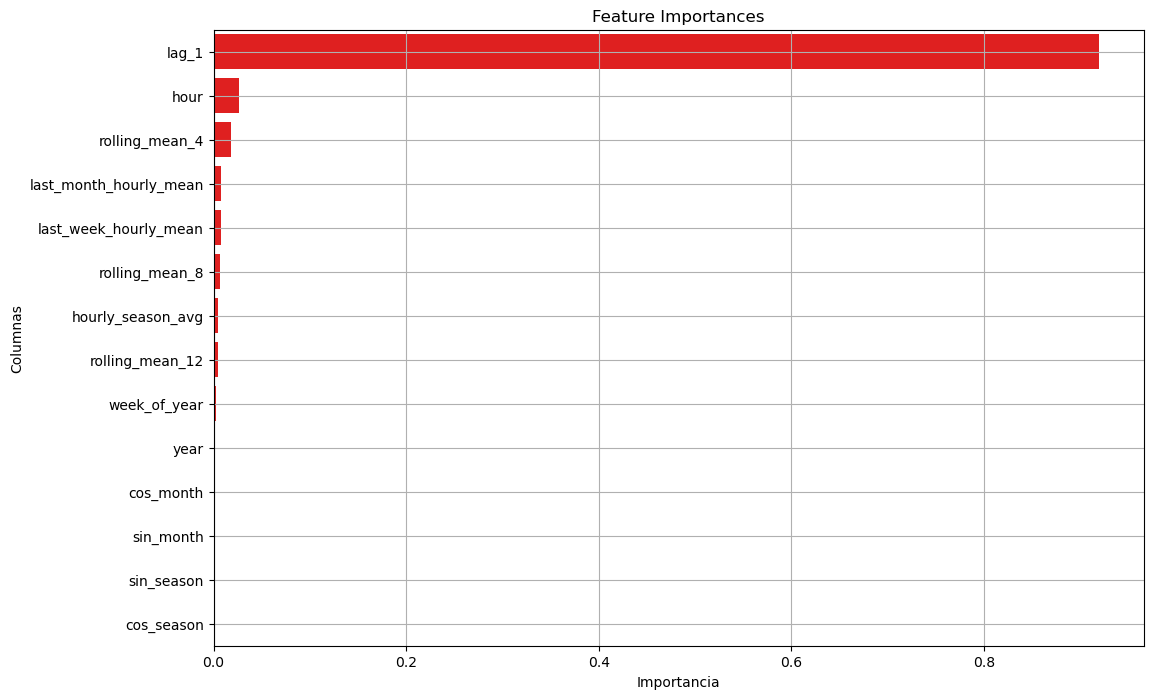

CPU times: total: 10.6 s
Wall time: 10.7 s


In [28]:
%%time
# Entrenamos el modelo
O3_model.fit(O3_x, O3_y)

# Calculamos Feature Importance
importances = O3_model.feature_importances_

df_importances = pd.DataFrame(data = zip(O3_x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [29]:
with open("../../models/O3_model_task_2.pkl", "bw") as file:
    pickle.dump(O3_model, file)

## CO MODEL

%%time
best_model (COx_train, COx_test, COy_train, COy_test, CO_y_scaler )

In [32]:
CO_model = RandomForestRegressor(**randomforest_best_params)

# Crear el objeto TimeSeriesSplit (por ejemplo, 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(CO_model, CO_x, CO_y, cv=tscv, scoring='r2')
print("R2 scores:", scores)
print("R2 promedio:", np.mean(scores))

R2 scores: [0.88872985 0.87740124 0.84076105 0.86744734 0.81299265]
R2 promedio: 0.8574664237146635


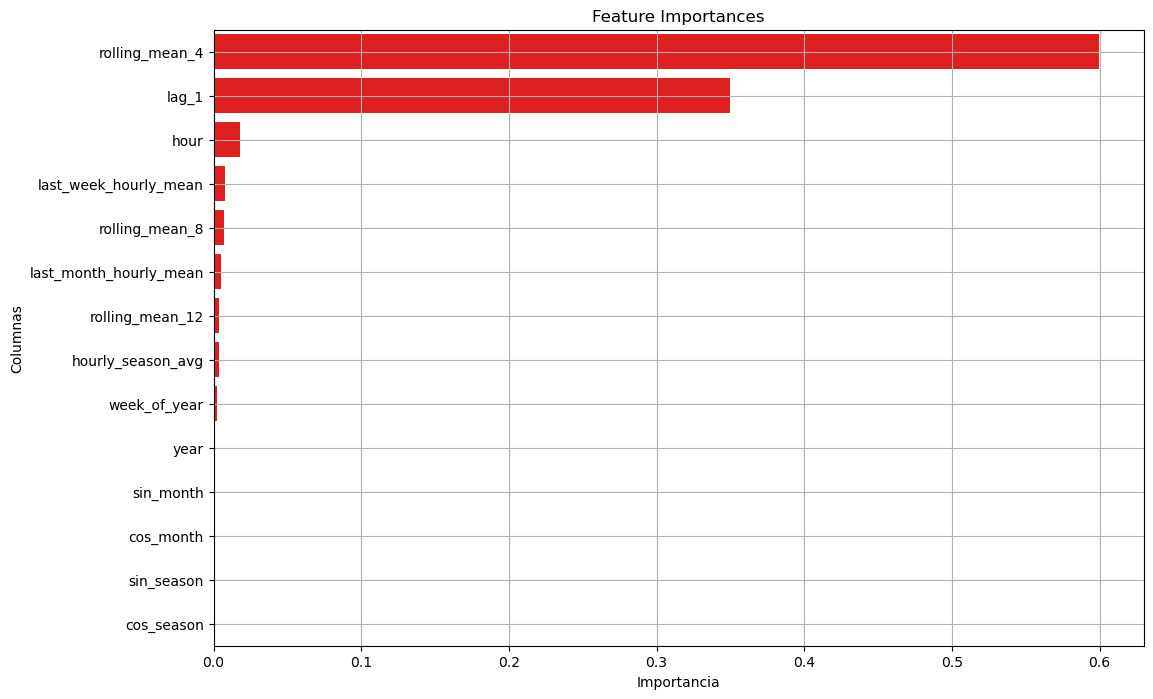

CPU times: total: 8.16 s
Wall time: 8.16 s


In [33]:
%%time

# Entrenamos el modelo
CO_model.fit(CO_x, CO_y)

# Calculamos Feature Importance
importances = CO_model.feature_importances_

df_importances = pd.DataFrame(data = zip(CO_x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [34]:
with open("../../models/CO_model_task_2.pkl", "bw") as file:
    pickle.dump(CO_model, file)

## PM10 MODEL

%%time
best_model (PM10x_train, PM10x_test, PM10y_train, PM10y_test, PM10_y_scaler  )

In [37]:
PM10_model = GradientBoostingRegressor(**gradient_best_params)

# Crear el objeto TimeSeriesSplit (por ejemplo, 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(PM10_model, PM10_x, PM10_y, cv=tscv, scoring='r2')
print("R2 scores:", scores)
print("R2 promedio:", np.mean(scores))

R2 scores: [0.88119649 0.89907926 0.92376998 0.92370519 0.93210101]
R2 promedio: 0.9119703844706006


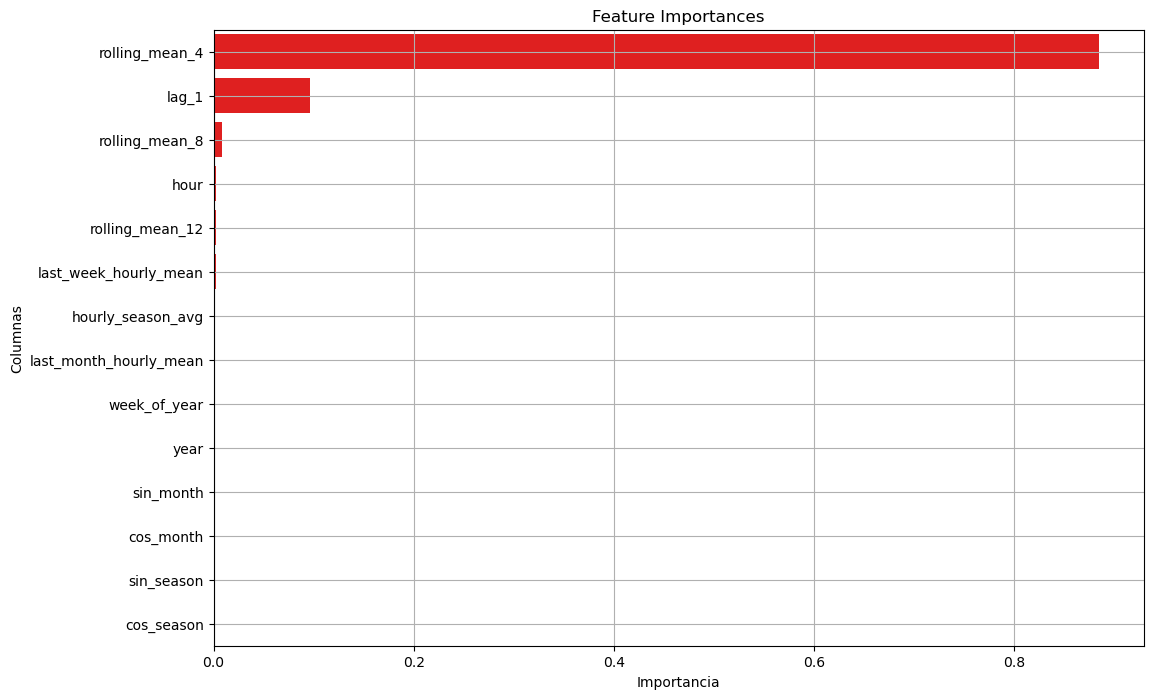

CPU times: total: 7.08 s
Wall time: 7.17 s


In [38]:
%%time

# Entrenamos el modelo
PM10_model.fit(PM10_x, PM10_y)

# Calculamos Feature Importance
importances = PM10_model.feature_importances_

df_importances = pd.DataFrame(data = zip(PM10_x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [39]:
with open("../../models/PM10_model_task_2.pkl", "bw") as file:
    pickle.dump(PM10_model, file)

## PM2.5 MODEL

%%time
best_model (PM2_x_train, PM2_x_test, PM2_y_train, PM2_y_test, PM2_5_y_scaler )

In [42]:
PM2_model = RandomForestRegressor(**randomforest_best_params)

# Crear el objeto TimeSeriesSplit (por ejemplo, 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(PM2_model, PM2_x, PM2_y, cv=tscv, scoring='r2')
print("R2 scores:", scores)
print("R2 promedio:", np.mean(scores))

R2 scores: [0.87652996 0.89474657 0.91644919 0.93018758 0.92340536]
R2 promedio: 0.9082637303405721


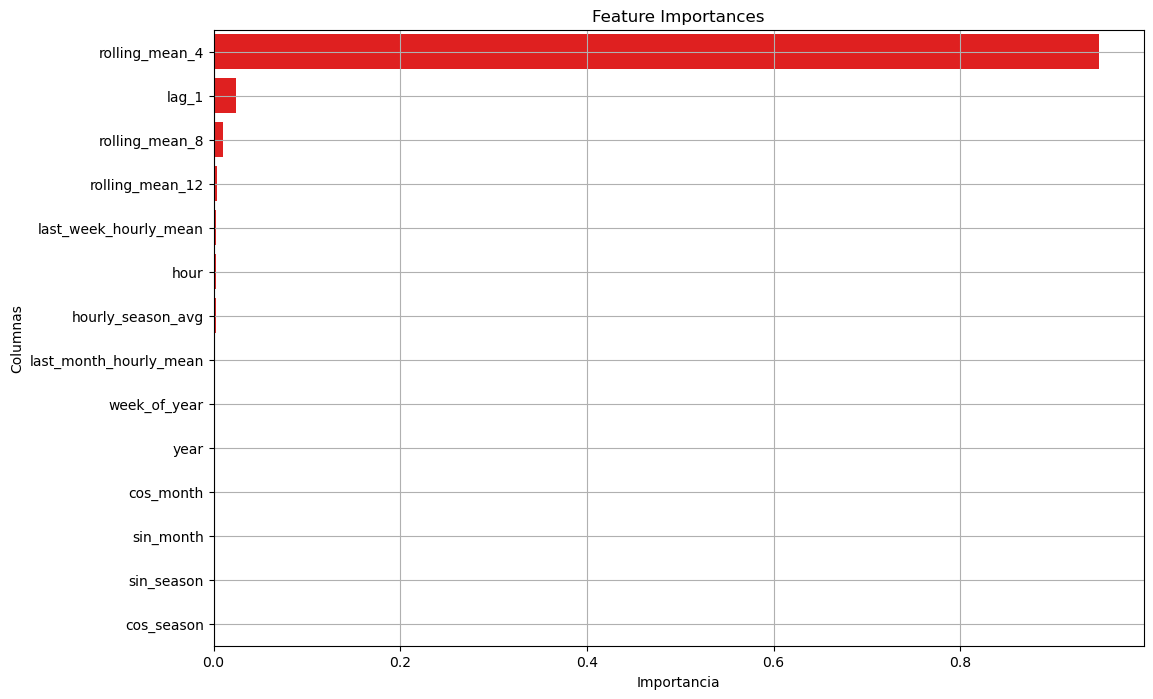

CPU times: total: 11.9 s
Wall time: 12.1 s


In [43]:
%%time

# Entrenamos el modelo
PM2_model.fit(PM2_x, PM2_y)

# Calculamos Feature Importance
importances = PM2_model.feature_importances_

df_importances = pd.DataFrame(data = zip(PM2_x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [44]:
with open("../../models/PM2_model_task_2.pkl", "bw") as file:
    pickle.dump(PM2_model, file)

## Gridsearch

## Predictions

In [47]:
def descaling_df(df, x_scaler, y_scaler):
    """
    Desescala un DataFrame que fue escalado previamente.
    
    Parámetros:
      df: DataFrame escalado. Se asume que tiene la columna "Measurement value" y el resto son features.
      x_scaler: El escalador (MinMaxScaler, StandardScaler, etc.) que se usó para las features.
      y_scaler: Escalador usado para la variable objetivo ("Measurement value").
    
    Retorna:
      df_copy: DataFrame con las features y "Measurement value" desescaladas a su escala original.
    """
    dates = df["Measurement date"].reset_index(drop=True)
    x = df.drop(columns=["Measurement date", "Measurement value"])
    y = df['Measurement value']
    
    # Desescalar las features
    x_descaled = pd.DataFrame(x_scaler.inverse_transform(x), columns=x.columns)
    x_descaled['year'] = x_descaled['year'].round().astype(int)
    x_descaled['hour'] = x_descaled['hour'].round().astype(int)
    x_descaled['week_of_year'] = x_descaled['week_of_year'].round().astype(int)
    
    # Desescalar el target
    y_descaled = y_scaler.inverse_transform(y.values.reshape(-1,1)).ravel()
    y_descaled = pd.Series(y_descaled, name='Measurement value')
    
    # Concatenar features y target
    df_copy = pd.concat([dates, x_descaled, y_descaled], axis=1)
    
    return df_copy

# Aplicar la función para cada DataFrame histórico:
df_SO2_descaled = descaling_df(df_SO2, SO2_x_scaler, SO2_y_scaler)
df_NO2_descaled = descaling_df(df_NO2, NO2_x_scaler, NO2_y_scaler)
df_O3_descaled = descaling_df(df_O3, O3_x_scaler, O3_y_scaler)
df_CO_descaled = descaling_df(df_CO, CO_x_scaler, CO_y_scaler)
df_PM10_descaled = descaling_df(df_PM10, PM10_x_scaler, PM10_y_scaler)
df_PM2_5_descaled = descaling_df(df_PM2_5, PM2_5_x_scaler, PM2_5_y_scaler)

In [48]:
def assign_season(month):
    # Asigna la temporada numérica: 1 (invierno), 2 (primavera), 3 (verano), 4 (otoño)
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4

def prepare_initial_values(df):
    """
    A partir del dataset histórico (df), calcula:
      - initial_history: Lista con los últimos 12 valores de 'Measurement value'.
      - initial_last_week: Valor inicial para last_week_hourly_mean, obtenido como el promedio de 'Measurement value'
                           de la hora correspondiente en la semana anterior al último registro.
      - static_hourly_season_avg: Promedio de 'Measurement value' para la combinación (season, hour) del último registro.
    
    Se asume que df contiene al menos las columnas "Measurement date" y "Measurement value". Si existe la columna
    "season" se usará para calcular static_hourly_season_avg; en caso contrario, se asigna la temporada en función del mes.
    """
    # Asegurarse de que la columna de fecha esté en formato datetime
    df["Measurement date"] = pd.to_datetime(df["Measurement date"])
    
    # Ordenar cronológicamente
    df_sorted = df.sort_values("Measurement date")
    
    # Extraer los últimos 12 valores de "Measurement value"
    initial_history = df_sorted["Measurement value"].tail(12).tolist()
    
    # Tomar la fecha y la hora del último registro
    last_date = df_sorted["Measurement date"].iloc[-1]
    last_hour = last_date.hour
    last_year = last_date.year
    
    # Calcular initial_last_week:
    # Filtrar registros de la semana anterior al último registro
    week_start = last_date - pd.Timedelta(days=7)
    df_last_week = df_sorted[df_sorted["Measurement date"] >= week_start]
    # Calcular el promedio de "Measurement value" por hora en esa semana
    hourly_week_avg = df_last_week.groupby(df_last_week["Measurement date"].dt.hour)["Measurement value"].mean()
    # Usar el promedio correspondiente a la hora del último registro
    initial_last_week = hourly_week_avg.loc[last_hour] if last_hour in hourly_week_avg.index else None
    
    # Calcular static_hourly_season_avg:
    last_season = assign_season(last_date.month)
    
    # Filtrar registros que correspondan a la misma season    
    df_season = df_sorted.copy()
    df_season["season"] = df_season["Measurement date"].dt.month.apply(assign_season)
    df_season = df_season[df_season["season"] == last_season]
    df_season = df_season[(df_season["season"] == last_season) & (df_season["Measurement date"].dt.year == last_year)]
    
    # Calcular el promedio por hora en este subconjunto y extraer el de la hora del último registro
    static_hourly_season_avg = df_season.groupby(df_season["Measurement date"].dt.hour)["Measurement value"].mean().loc[last_hour]
    
    # Calcular last_month_hourly_mean de forma estática:
    # Determinar el mes anterior
    
    if last_date.month == 1:
        previous_month = 12
        previous_year = last_year - 1
    else:
        previous_month = last_date.month - 1
        previous_year = last_year
        
    # Filtrar registros del mes anterior
    df_last_month = df_sorted[(df_sorted["Measurement date"].dt.month == previous_month) & 
                              (df_sorted["Measurement date"].dt.year == previous_year)]
    
    # Calcular el promedio por hora y extraer el correspondiente a la hora del último registro
    last_month_hourly_mean = df_last_month.groupby(df_last_month["Measurement date"].dt.hour)["Measurement value"].mean().loc[last_hour]
    
    return initial_history, initial_last_week, static_hourly_season_avg, last_month_hourly_mean

In [49]:
def iterative_predict_for_period_from_dataset(start_date, end_date, model, feature_scaler, target_scaler,
                                                freq, station, historical_df):
    """
    Realiza un forecast iterativo para el período dado utilizando el dataset histórico para
    calcular las condiciones iniciales. Durante la iteración se actualizan recursivamente:
      - lag_1, rolling_mean_4, rolling_mean_8, rolling_mean_12 (calculados a partir de la "historia")
      - last_week_hourly_mean, que se actualiza con cada predicción.
    
    Los demás features (derivados directamente de la fecha) se calculan en cada iteración.
    
    Parámetros:
      start_date, end_date: rango de predicción (str o datetime)
      model: modelo entrenado
      feature_scaler: scaler usado en el entrenamiento para las features
      target_scaler: scaler usado en el entrenamiento para la variable objetivo
      freq: frecuencia (por ejemplo, 'H')
      station: código de la estación (para la llave del dict final)
      historical_df: dataset histórico (DataFrame) con las columnas "Measurement date" y "Measurement value"
                     y, de preferencia, "season".
    
    Retorna:
      Un diccionario con la estructura: { "<station>": { "YYYY-MM-DD HH:MM:SS": predicción, ... } }
    """
    # Preparar condiciones iniciales a partir del dataset
    initial_history, initial_last_week, static_hourly_season_avg, last_month_hourly_mean = prepare_initial_values(historical_df)
    
    dates = pd.date_range(start=start_date, end=end_date, freq=freq)
    predictions = {}
    
    # Inicializar la historia y last_week_hourly_mean
    history = initial_history.copy()
    last_week_value = initial_last_week
    
    for dt in dates:
        year = dt.year
        month = dt.month
        hour = dt.hour
        week_of_year = int(dt.isocalendar().week)
        
        # Calcular las features recursivas a partir de la historia
        lag_1 = history[-1]
        rolling_mean_4 = np.mean(history[-4:]) if len(history) >= 4 else lag_1
        rolling_mean_8 = np.mean(history[-8:]) if len(history) >= 8 else lag_1
        rolling_mean_12 = np.mean(history[-12:]) if len(history) >= 12 else lag_1
        
        # Features derivadas de la fecha
        season = assign_season(month)
        sin_season = np.sin(2 * np.pi * (season - 1) / 4)
        cos_season = np.cos(2 * np.pi * (season - 1) / 4)
        sin_month = np.sin(2 * np.pi * (month - 1) / 12)
        cos_month = np.cos(2 * np.pi * (month - 1) / 12)
        
        # Construir el vector de features. Usamos static_hourly_season_avg obtenido del histórico.
        data = {
            "hour": hour,
            "week_of_year": week_of_year,
            "year": year,
            "lag_1": lag_1,
            "rolling_mean_4": rolling_mean_4,
            "rolling_mean_8": rolling_mean_8,
            "rolling_mean_12": rolling_mean_12,
            "hourly_season_avg": static_hourly_season_avg,
            "last_week_hourly_mean": last_week_value,
            "last_month_hourly_mean" : last_month_hourly_mean,
            "sin_season": sin_season,
            "cos_season": cos_season,
            "sin_month": sin_month,
            "cos_month": cos_month
        }
        
        X_current = pd.DataFrame([data])
        X_current_scaled = feature_scaler.transform(X_current)
        X_current_scaled = pd.DataFrame(X_current_scaled, columns=X_current.columns)
        
        y_pred_scaled = model.predict(X_current_scaled)
        y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()[0]
        y_pred = round(y_pred, 3)
        
        predictions[dt.strftime("%Y-%m-%d %H:%M:%S")] = y_pred
        
        # Actualizar recursivamente la historia y last_week_hourly_mean
        history.append(y_pred)
        if len(history) > 12:
            history = history[-12:]
        last_week_value = y_pred
    
    return {str(station): predictions}

## Results

In [126]:
SO2_dict = iterative_predict_for_period_from_dataset(
    start_date='2023-07-01 00:00:00',
    end_date='2023-07-31 23:00:00',
    model=SO2_model,
    feature_scaler=SO2_x_scaler,
    target_scaler=SO2_y_scaler,
    freq='H',
    station=206,
    historical_df=df_SO2_descaled
)

In [127]:
len(SO2_dict['206'])

744

In [128]:
NO2_dict = iterative_predict_for_period_from_dataset(
    start_date='2023-08-01 00:00:00',
    end_date='2023-08-31 23:00:00',
    model=NO2_model,
    feature_scaler=NO2_x_scaler,
    target_scaler=NO2_y_scaler,
    freq='H',
    station=211,
    historical_df=df_NO2_descaled
)

In [129]:
len(NO2_dict['211'])

744

In [132]:
O3_dict = iterative_predict_for_period_from_dataset(
    start_date='2023-09-01 00:00:00',
    end_date='2023-09-30 23:00:00',
    model=O3_model,
    feature_scaler=O3_x_scaler,
    target_scaler=O3_y_scaler,
    freq='H',
    station=217,
    historical_df=df_O3_descaled
)

In [133]:
len(O3_dict['217'])

720

In [134]:
CO_dict = iterative_predict_for_period_from_dataset(
    start_date='2023-10-01 00:00:00',
    end_date='2023-10-31 23:00:00',
    model=CO_model,
    feature_scaler=CO_x_scaler,
    target_scaler=CO_y_scaler,
    freq='H',
    station=219,
    historical_df=df_CO_descaled
)

In [135]:
len(CO_dict['219'])

744

In [136]:
PM10_dict = iterative_predict_for_period_from_dataset(
    start_date='2023-11-01 00:00:00',
    end_date='2023-11-30 23:00:00',
    model=PM10_model,
    feature_scaler=PM10_x_scaler,
    target_scaler=PM10_y_scaler,
    freq='H',
    station=225,
    historical_df=df_PM10_descaled
)

In [137]:
len(PM10_dict['225'])

720

In [138]:
PM2_dict = iterative_predict_for_period_from_dataset(
    start_date='2023-12-01 00:00:00',
    end_date='2023-12-31 23:00:00',
    model=PM2_model,
    feature_scaler=PM2_5_x_scaler,
    target_scaler=PM2_5_y_scaler,
    freq='H',
    station=228,
    historical_df=df_PM2_5_descaled
)

In [139]:
len(PM2_dict['228'])

744

In [140]:
predictions = {
    "target": {}
}

predictions["target"].update(SO2_dict)
predictions["target"].update(NO2_dict)
predictions["target"].update(O3_dict)
predictions["target"].update(CO_dict)
predictions["target"].update(PM10_dict)
predictions["target"].update(PM2_dict)

with open("../../predictions/predictions_task_2.json", "w") as f:
    json.dump(predictions, f, indent=4)